### Лабораторная работа №2 "Тематическое моделирование"

Провести тематическое моделирование использую набор данных, полученный в предыдущей лабораторной работе (для векторизации текста использовать модель мешка слов и масштабирование данных при помощи tf-idf, использовать 3 модели для тематического моделирования). Выбрать оптимальное количество тем, оценить результаты. Показать на примере работу лучшей модели (на входе текст на выходе список тем).

In [8]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install spacy

In [10]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install mglearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install bert-serving-server

In [ ]:
pip install bert-serving-client

In [93]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pyLDAvis
#import pyLDAvis.gensim 

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

import mglearn
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.datasets import fetch_20newsgroups

from bert_serving.client import BertClient
from scipy.sparse import csr_matrix

## 1. Тематическое моделирование. Пострение моделей

In [68]:
# Загрузим данные, полученные и предобработанные в лабораторной работе 1
df = pd.read_csv("data_after_preprocess_jupiter.csv") 
df.head()

,Unnamed: 0,comments,titles,sentiments,nicemarks,badmarks
0,0,начало обучение навык программирония небольшой...,Превращение новичка в профессионала: моя исто...,5.0,125,54
1,1,удобный понятный платформа онлайн обучение каж...,Обучение в GeekBrains,5.0,0,0
2,2,перевести деньга вернуть иметь это вид сразу и...,Не вздумайте ни в коем случае приобретать кур...,1.0,0,0
3,3,обучение весь материал слишком поверхностный р...,Не то что ты ждешь (Продвинутый геймдизайн),2.0,0,0
4,4,нравиться курс подходить обучение задержка ста...,хорошая онлайн школа,5.0,0,0


In [69]:
# Готовим данные при помощи мешка слов. Масштабируем данные при помощи статистической меры TF-IDF.
vect = TfidfVectorizer(ngram_range=(1, 3), binary= False,max_features=2000, min_df=0.018 ) 

X = vect.fit_transform(df['comments'].values)

feature_names = vect.get_feature_names()
print("Первые 50 признаков:\n{}".format(feature_names[:50]))

Первые 50 признаков:
['digital', 'digital маркетинг', 'gb', 'gb ru', 'geekbrains', 'geekbrains давно', 'geekbrains давно решаться', 'geekbrains однозначно', 'geekbrains помочь', 'geekbrains учиться', 'geekbrains это', 'illustrator', 'it', 'java', 'photoshop', 'product', 'python', 'python разработка', 'ru', 'smm', 'telegram', 'tutortop', 'unity', 'ux', 'web', 'абсолютно', 'агрегатор', 'адекватный', 'активно', 'актуальный', 'анализ', 'аналитик', 'аналитика', 'анастасия', 'английский', 'андроид', 'андроид разработчик', 'база', 'базовый', 'базовый знание', 'банк', 'бесконечно', 'бесплатно', 'бесплатный', 'бесплатный курс', 'бизнес', 'благодарный', 'благодаря', 'близкий', 'бог']


In [70]:
# Посмотрим получившийся словарь
print("Размер словаря: {}".format(len(vect.vocabulary_)))
print("Содержимое словаря:\n {}".format(vect.vocabulary_))

Размер словаря: 1073
Содержимое словаря:
 {'начало': 418, 'обучение': 479, 'навык': 399, 'небольшой': 429, 'geekbrains': 4, 'помочь': 631, 'знание': 248, 'структурировать': 917, 'закрепить': 230, 'позволить': 605, 'начать': 420, 'профессиональный': 740, 'деятельность': 171, 'кроме': 319, 'сам': 810, 'раз': 761, 'неделя': 433, 'педагог': 570, 'такой': 934, 'дать': 156, 'объясняться': 490, 'именно': 268, 'рассказать': 773, 'занятие': 233, 'вопрос': 97, 'подготовка': 593, 'несколько': 444, 'первый': 571, 'лекция': 342, 'час': 1037, 'длиться': 181, 'понять': 639, 'это': 1057, 'разбирать': 763, 'нужно': 458, 'далёкий': 153, 'становиться': 903, 'решение': 798, 'смена': 858, 'преподаватель': 679, 'очень': 560, 'круто': 321, 'дело': 165, 'каждый': 287, 'практиковать': 664, 'специалист': 879, 'узнать': 977, 'какой': 291, 'область': 468, 'работа': 752, 'делать': 164, 'вывод': 117, 'что': 1050, 'кстати': 323, 'официальный': 557, 'документ': 188, 'вернуть': 73, 'определённый': 513, 'сумма': 922, '

In [71]:
# В качестве первого алгоритма тематического моделирования возьмем LDA (Латентное размещение Дирихле)
lda = LatentDirichletAllocation(n_components=10, learning_method="online",
                                max_iter=25, random_state=1)

document_topics = lda.fit_transform(X)
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=range(15), feature_names=feature_names, 
sorting=sorting, topics_per_chunk=5, n_words=20)

topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

# Название тем из 2х топовых слов
topic_names 

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
ученик        вода          курс          сторона       оплатить      
сертификат    получение     стоить свой   плохо         опыт обучение 
вебинар которыйпонятно       стоить свой деньгаобучение это  материал      
анастасия     никакой       свой деньга   тысяча рубль  обучение      
вебинар       слово         ждать         сто           либо          
it            веб аналитика стоить        java          опыт          
бесплатный    информация    деньга        тысяча        написать заявление
английский    время         совершенно    долгий        виноватый     
условие       знакомый      нравиться     такой цена    убедиться     
учитель       знание        тонкость      цена          возврат       
который       веб           долго         инструмент    заявление     
необходимый   интернет маркетологподходить     слишком       надеять

[' 0 ученик сертификат',
 ' 1 вода получение',
 ' 2 курс стоить свой',
 ' 3 сторона плохо',
 ' 4 оплатить опыт обучение',
 ' 5 перевести новичок',
 ' 6 целое большинство',
 ' 7 курс это',
 ' 8 курс обучение',
 ' 9 ваш мой работа']

In [72]:
# В качестве второго алгоритма тематического моделирования возьмем NMF (неотрицательная матричная факторизация)
nmf = NMF(n_components=10,max_iter=25, random_state=1, alpha=0, l1_ratio=.5)

document_topics = nmf.fit_transform(X)
sorting = np.argsort(nmf.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=range(15), feature_names=feature_names, 
sorting=sorting, topics_per_chunk=5, n_words=20)

topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

# Название тем из 2х топовых слов
topic_names 

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
лекция        smm           связь         стоить свой деньгапрофессия     
каждый        практика      очень         свой деньга   новый         
преподаватель новичок       обратный связьстоить свой   искать        
обучение      база          обратный      интернет      новый профессия
именно        задание       задание       стоить        стать         
вопрос        знание        домашний      свой          тестирование  
geekbrains    научить       домашний заданиеденьга        работа        
какой         просто        преподаватель мочь          освоить       
сам           ошибка        урок          курс          веб           
знание        специальность новый         продвижение   маркетинг     
простой       указывать     узнать новый  разбираться   человек       
сертификат    указывать ошибкагруппа        тонкость      аналитика   

[' 0 лекция каждый',
 ' 1 smm практика',
 ' 2 связь очень',
 ' 3 стоить свой деньга свой деньга',
 ' 4 профессия новый',
 ' 5 бесплатный бесплатный курс',
 ' 6 вода получение',
 ' 7 всё проходить',
 ' 8 формат дистанционный формат',
 ' 9 оплатить вернуть']

In [73]:
# В качестве третьего алгоритма тематического моделирования возьмем LSA (латентный семантический анализ)
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)

document_topics = svd.fit_transform(X)
sorting = np.argsort(svd.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=range(15), feature_names=feature_names, 
sorting=sorting, topics_per_chunk=5, n_words=20)

topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

# Название тем из 2х топовых слов
topic_names 

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
курс          smm           очень         бесплатный    профессия     
это           специальность задание       лекция        новый         
обучение      база          домашний      каждый        бесплатный    
преподаватель учиться       связь         новый         бесплатный курс
geekbrains    программист   домашний заданиевебинар       освоить       
который       профессия     обратный связьочень         вариант       
учиться       университет   обратный      язык          который       
новый         мой           урок          бесплатный курсit            
свой          говорить      преподаватель вуз           вариант профессия
очень         ошибка        учёба         сфера         выбор         
знание        работать      успеть        найти         информация    
профессия     результат     нрав          преподаватель смочь         

[' 0 курс это',
 ' 1 smm специальность',
 ' 2 очень задание',
 ' 3 бесплатный лекция',
 ' 4 профессия новый']

## 2. Оценка модели. Выбор оптимального количества тем

In [84]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(df['comments']))
print(data_words[:1])

[['начало', 'обучение', 'навык', 'программирония', 'небольшои', 'geekbrains', 'помочь', 'знание', 'структурировать', 'закрепить', 'позволить', 'начать', 'деятельность', 'кроме', 'сам', 'обучение', 'раз', 'неделя', 'персональныи', 'беседа', 'педагог', 'такои', 'беседа', 'пожалуи', 'дать', 'знание', 'подробность', 'объясняться', 'именно', 'рассказать', 'занятие', 'вопрос', 'проговариваться', 'пробел', 'подготовка', 'несколько', 'смущать', 'первыи', 'лекция', 'среднее', 'час', 'длиться', 'понять', 'это', 'разбирать', 'несложныи', 'вопрос', 'нужно', 'далекии', 'длинныи', 'становиться', 'лекция', 'оригинальныи', 'решение', 'geekbrains', 'периодическии', 'смена', 'преподаватель', 'это', 'очень', 'круто', 'сам', 'дело', 'каждыи', 'практиковать', 'специалист', 'каждыи', 'поговорить', 'узнать', 'именно', 'точка', 'зрение', 'какои', 'область', 'работа', 'делать', 'вывод', 'что', 'склоняться', 'сам', 'кстати', 'обучение', 'официальныи', 'документ', 'налоговыи', 'вернуть', 'определенныи', 'сумма',

In [85]:
# Создадим словарь
id2word = corpora.Dictionary(data_words)

# Создадим корпус
texts = data_words

# Вычислим частоты
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 3), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2)]]


In [86]:
id2word[0]

'geekbrains'

In [87]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('geekbrains', 2),
  ('беседа', 2),
  ('бонус', 1),
  ('вернуть', 1),
  ('вопрос', 2),
  ('вывод', 1),
  ('далекии', 1),
  ('дать', 1),
  ('делать', 1),
  ('дело', 1),
  ('деятельность', 1),
  ('длинныи', 1),
  ('длиться', 1),
  ('документ', 1),
  ('закрепить', 1),
  ('занятие', 1),
  ('знание', 2),
  ('зрение', 1),
  ('именно', 2),
  ('каждыи', 2),
  ('какои', 1),
  ('кроме', 1),
  ('круто', 1),
  ('кстати', 1),
  ('лекция', 2),
  ('навык', 1),
  ('налоговыи', 1),
  ('начало', 1),
  ('начать', 1),
  ('небольшои', 1),
  ('неделя', 1),
  ('несколько', 1),
  ('несложныи', 1),
  ('нужно', 1),
  ('область', 1),
  ('обучение', 3),
  ('объясняться', 1),
  ('определенныи', 1),
  ('оригинальныи', 1),
  ('официальныи', 1),
  ('очень', 1),
  ('педагог', 1),
  ('первыи', 1),
  ('периодическии', 1),
  ('персональныи', 1),
  ('поговорить', 1),
  ('подготовка', 1),
  ('подробность', 1),
  ('пожалуи', 1),
  ('позволить', 1),
  ('помочь', 1),
  ('понять', 1),
  ('практиковать', 1),
  ('преподаватель

In [89]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
lda_model.print_topics()

[(0,
  '0.013*"интернет" + 0.011*"курс" + 0.011*"обучение" + 0.011*"которыи" + 0.009*"учиться" + 0.009*"новыи" + 0.009*"свои" + 0.007*"преподаватель" + 0.007*"сказать" + 0.007*"знание"'),
 (1,
  '0.016*"обучение" + 0.012*"это" + 0.012*"работа" + 0.009*"мои" + 0.009*"материал" + 0.009*"итог" + 0.007*"курс" + 0.007*"начало" + 0.007*"год" + 0.007*"вести"'),
 (2,
  '0.021*"курс" + 0.017*"это" + 0.010*"поити" + 0.010*"понравиться" + 0.009*"учиться" + 0.008*"мочь" + 0.008*"знание" + 0.008*"профессия" + 0.007*"новыи" + 0.007*"программа"'),
 (3,
  '0.014*"обучение" + 0.013*"лекция" + 0.012*"гик" + 0.012*"образовательныи" + 0.011*"преподаватель" + 0.010*"дз" + 0.009*"курс" + 0.009*"тестирование" + 0.009*"хотеть" + 0.009*"веб"'),
 (4,
  '0.016*"это" + 0.012*"курс" + 0.010*"сам" + 0.008*"знать" + 0.008*"цена" + 0.008*"опыт" + 0.008*"обучение" + 0.008*"geekbrains" + 0.008*"практика" + 0.008*"школа"'),
 (5,
  '0.012*"деньга" + 0.011*"вернуть" + 0.009*"нравиться" + 0.009*"курс" + 0.009*"учиться" + 0

In [101]:
# Оценим модель. Cложность (Perplexity) модели и согласованность (Coherence) темы предоставляют удобную меру для оценки того, 
# насколько хорошо выполнено тематическое моделирование.

# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.596950462500402

Coherence Score:  0.3303269167132132


In [105]:
# Визуализируем полученные частоты
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.062028  0.057315       1        1  15.515891
13    -0.083973  0.086164       2        1  10.687258
11     0.131141  0.009473       3        1   9.894745
12    -0.100140 -0.038950       4        1   8.434137
7      0.008508  0.043204       5        1   7.411733
0      0.005203 -0.036954       6        1   6.926930
4     -0.019358  0.039631       7        1   6.626194
10     0.071946  0.059334       8        1   6.330814
6     -0.056610  0.056567       9        1   6.235713
9     -0.037663 -0.083641      10        1   6.188871
2      0.098679 -0.008766      11        1   5.701430
1      0.041630  0.001879      12        1   5.005513
3     -0.022905 -0.155681      13        1   3.301729
5      0.025567 -0.029574      14        1   1.739042, topic_info=        Term       Freq      Total Category  logprob  loglift
40     очень  23.000000  23.000000  Default  30.0000  30.0000
24    лекция  11.000000  11.000000  Default  29.0000  29.0000
94    деньга  13.000000  13.000000  Default  28.0000  28.0000
116  учиться  31.000000  31.000000  Default  27.0000  27.0000
182      год  15.000000  15.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
459    особо   0.461145   4.139437  Topic14  -5.4054   1.8572
304    стать   0.461142  13.755711  Topic14  -5.4054   0.6563
284    время   0.460813  26.285694  Topic14  -5.4061   0.0080
111    сразу   0.460721   7.882516  Topic14  -5.4063   1.2122
486    наити   0.460569   9.562892  Topic14  -5.4067   1.0187

[954 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
320       1  0.322010      gb
320       4  0.214673      gb
320       5  0.107337      gb
320       6  0.214673      gb
320      11  0.214673      gb
...     ...       ...     ...
88       10  0.148681    язык
88       13  0.148681    язык
585       1  0.141577  яндекс
585       3  0.283154  яндекс
585       5  0.424732  яндекс

[1767 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 14, 12, 13, 8, 1, 5, 11, 7, 10, 3, 2, 4, 6])

In [108]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [110]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=40, step=6)

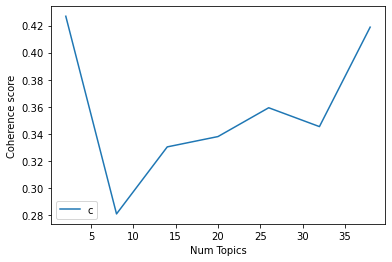

In [111]:
# Посмотрим график
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [112]:
# Выведем оценки метрики согласованности. Мы видим наилучшее значение метрики при количестве тем = 2
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4269
Num Topics = 8  has Coherence Value of 0.2808
Num Topics = 14  has Coherence Value of 0.3303
Num Topics = 20  has Coherence Value of 0.338
Num Topics = 26  has Coherence Value of 0.3593
Num Topics = 32  has Coherence Value of 0.3453
Num Topics = 38  has Coherence Value of 0.4189


In [115]:
# Пример работы лучшей модели
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.013*"интернет" + 0.011*"курс" + 0.011*"обучение" + 0.011*"которыи" + '
  '0.009*"учиться" + 0.009*"новыи" + 0.009*"свои" + 0.007*"преподаватель" + '
  '0.007*"сказать" + 0.007*"знание"'),
 (1,
  '0.016*"обучение" + 0.012*"это" + 0.012*"работа" + 0.009*"мои" + '
  '0.009*"материал" + 0.009*"итог" + 0.007*"курс" + 0.007*"начало" + '
  '0.007*"год" + 0.007*"вести"'),
 (2,
  '0.021*"курс" + 0.017*"это" + 0.010*"поити" + 0.010*"понравиться" + '
  '0.009*"учиться" + 0.008*"мочь" + 0.008*"знание" + 0.008*"профессия" + '
  '0.007*"новыи" + 0.007*"программа"'),
 (3,
  '0.014*"обучение" + 0.013*"лекция" + 0.012*"гик" + 0.012*"образовательныи" + '
  '0.011*"преподаватель" + 0.010*"дз" + 0.009*"курс" + 0.009*"тестирование" + '
  '0.009*"хотеть" + 0.009*"веб"'),
 (4,
  '0.016*"это" + 0.012*"курс" + 0.010*"сам" + 0.008*"знать" + 0.008*"цена" + '
  '0.008*"опыт" + 0.008*"обучение" + 0.008*"geekbrains" + 0.008*"практика" + '
  '0.008*"школа"'),
 (5,
  '0.012*"деньга" + 0.011*"вернуть" + 0.00